In [60]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import plotly.graph_objs as go
from plotly.subplots import make_subplots
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, roc_auc_score, ConfusionMatrixDisplay, roc_curve, auc
from sklearn.model_selection import KFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn import svm, tree 
from sklearn.model_selection import GridSearchCV, cross_val_score
from collections import OrderedDict
from operator import itemgetter

In [61]:
import warnings
warnings.filterwarnings( 'ignore' )

In [62]:
df = pd.read_csv('~/Glioma-Grading-Classification/TCGA_GBM_LGG_Mutations_all.csv')
df


,Grade,Project,Case_ID,Gender,Age_at_diagnosis,Primary_Diagnosis,Race,IDH1,TP53,ATRX,...,FUBP1,RB1,NOTCH1,BCOR,CSMD3,SMARCA4,GRIN2A,IDH2,FAT4,PDGFRA
0,LGG,TCGA-LGG,TCGA-DU-8164,Male,51 years 108 days,"Oligodendroglioma, NOS",white,MUTATED,NOT_MUTATED,NOT_MUTATED,...,MUTATED,NOT_MUTATED,NOT_MUTATED,NOT_MUTATED,NOT_MUTATED,NOT_MUTATED,NOT_MUTATED,NOT_MUTATED,NOT_MUTATED,NOT_MUTATED
1,LGG,TCGA-LGG,TCGA-QH-A6CY,Male,38 years 261 days,Mixed glioma,white,MUTATED,NOT_MUTATED,NOT_MUTATED,...,NOT_MUTATED,NOT_MUTATED,NOT_MUTATED,NOT_MUTATED,NOT_MUTATED,NOT_MUTATED,NOT_MUTATED,NOT_MUTATED,NOT_MUTATED,NOT_MUTATED
2,LGG,TCGA-LGG,TCGA-HW-A5KM,Male,35 years 62 days,"Astrocytoma, NOS",white,MUTATED,MUTATED,MUTATED,...,NOT_MUTATED,NOT_MUTATED,NOT_MUTATED,NOT_MUTATED,NOT_MUTATED,NOT_MUTATED,NOT_MUTATED,NOT_MUTATED,NOT_MUTATED,NOT_MUTATED
3,LGG,TCGA-LGG,TCGA-E1-A7YE,Female,32 years 283 days,"Astrocytoma, anaplastic",white,MUTATED,MUTATED,MUTATED,...,NOT_MUTATED,NOT_MUTATED,NOT_MUTATED,NOT_MUTATED,NOT_MUTATED,NOT_MUTATED,NOT_MUTATED,NOT_MUTATED,MUTATED,NOT_MUTATED
4,LGG,TCGA-LGG,TCGA-S9-A6WG,Male,31 years 187 days,"Astrocytoma, anaplastic",white,MUTATED,MUTATED,MUTATED,...,NOT_MUTATED,NOT_MUTATED,NOT_MUTATED,NOT_MUTATED,NOT_MUTATED,NOT_MUTATED,NOT_MUTATED,NOT_MUTATED,NOT_MUTATED,NOT_MUTATED
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
857,GBM,TCGA-GBM,TCGA-19-5959,Female,77 years 325 days,Glioblastoma,white,NOT_MUTATED,NOT_MUTATED,NOT_MUTATED,...,NOT_MUTATED,NOT_MUTATED,NOT_MUTATED,NOT_MUTATED,NOT_MUTATED,NOT_MUTATED,NOT_MUTATED,NOT_MUTATED,NOT_MUTATED,NOT_MUTATED
858,GBM,TCGA-GBM,TCGA-16-0846,Male,85 years 65 days,Glioblastoma,white,NOT_MUTATED,MUTATED,NOT_MUTATED,...,NOT_MUTATED,NOT_MUTATED,NOT_MUTATED,NOT_MUTATED,NOT_MUTATED,NOT_MUTATED,NOT_MUTATED,NOT_MUTATED,NOT_MUTATED,NOT_MUTATED
859,GBM,TCGA-GBM,TCGA-28-1746,Female,77 years 178 days,Glioblastoma,white,NOT_MUTATED,MUTATED,NOT_MUTATED,...,NOT_MUTATED,NOT_MUTATED,NOT_MUTATED,NOT_MUTATED,NOT_MUTATED,NOT_MUTATED,NOT_MUTATED,NOT_MUTATED,NOT_MUTATED,NOT_MUTATED
860,GBM,TCGA-GBM,TCGA-32-2491,Male,63 years 121 days,Glioblastoma,white,NOT_MUTATED,MUTATED,NOT_MUTATED,...,NOT_MUTATED,MUTATED,NOT_MUTATED,NOT_MUTATED,NOT_MUTATED,NOT_MUTATED,NOT_MUTATED,NOT_MUTATED,NOT_MUTATED,NOT_MUTATED


## Data preprocessing

In [63]:
for i in df.columns:
    print(df[i].unique())

['LGG' 'GBM']
['TCGA-LGG' 'TCGA-GBM']
['TCGA-DU-8164' 'TCGA-QH-A6CY' 'TCGA-HW-A5KM' 'TCGA-E1-A7YE'
 'TCGA-S9-A6WG' 'TCGA-DB-A4X9' 'TCGA-P5-A5F4' 'TCGA-FG-A4MY'
 'TCGA-HT-A5R5' 'TCGA-DU-A76K' 'TCGA-QH-A6CV' 'TCGA-FG-5962'
 'TCGA-DU-6402' 'TCGA-DB-A75M' 'TCGA-DB-A4XG' 'TCGA-DU-5851'
 'TCGA-DB-A4XH' 'TCGA-HT-7874' 'TCGA-DH-A66D' 'TCGA-DU-5871'
 'TCGA-FG-A60J' 'TCGA-E1-A7Z3' 'TCGA-DU-7011' 'TCGA-VW-A8FI'
 'TCGA-DU-A7TB' 'TCGA-HT-7856' 'TCGA-TQ-A7RU' 'TCGA-HW-7486'
 'TCGA-DU-6399' 'TCGA-DU-A7TA' 'TCGA-HT-A5RA' 'TCGA-DB-5280'
 'TCGA-DU-6405' 'TCGA-S9-A7J1' 'TCGA-S9-A7J2' 'TCGA-HW-7495'
 'TCGA-FG-A710' 'TCGA-P5-A5ET' 'TCGA-DU-7300' 'TCGA-DU-A5TY'
 'TCGA-VM-A8CH' 'TCGA-R8-A6YH' 'TCGA-S9-A6WE' 'TCGA-HT-7681'
 'TCGA-KT-A7W1' 'TCGA-FG-5964' 'TCGA-S9-A6TX' 'TCGA-P5-A5F2'
 'TCGA-DU-5874' 'TCGA-DU-A5TT' 'TCGA-CS-5396' 'TCGA-DU-7302'
 'TCGA-S9-A6TW' 'TCGA-RY-A845' 'TCGA-HT-A61A' 'TCGA-DU-7018'
 'TCGA-HW-7489' 'TCGA-R8-A6ML' 'TCGA-DH-5144' 'TCGA-DU-7013'
 'TCGA-CS-4941' 'TCGA-WY-A85E' 'TCGA-DH-A7UR' '

In [64]:
# Replacing categorical variables with binary
df.replace({'MUTATED': 1, 'NOT_MUTATED': 0, 'Female': 1, 'Male': 0, 'LGG': 0, 'GBM': 1}, inplace=True)

In [65]:
# Removing rows with not identified variables
df = df[ (df['Gender'] != '--') & (df['Race'] != 'not reported')]

In [66]:
# Dropping unnessecary columns
df.drop(columns=(['Case_ID', 'Project', 'Primary_Diagnosis']), inplace=True)

In [67]:
# One hot encoding for race column
df = pd.concat([df, pd.get_dummies(df['Race'], prefix='Race')], axis=1)
df.drop(columns=['Race'], inplace=True)
df

,Grade,Gender,Age_at_diagnosis,IDH1,TP53,ATRX,PTEN,EGFR,CIC,MUC16,...,CSMD3,SMARCA4,GRIN2A,IDH2,FAT4,PDGFRA,Race_american indian or alaska native,Race_asian,Race_black or african american,Race_white
0,0,0,51 years 108 days,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
1,0,0,38 years 261 days,1,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,1
2,0,0,35 years 62 days,1,1,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
3,0,1,32 years 283 days,1,1,1,0,0,0,1,...,0,0,0,0,1,0,0,0,0,1
4,0,0,31 years 187 days,1,1,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
857,1,1,77 years 325 days,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,1
858,1,0,85 years 65 days,0,1,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,1
859,1,1,77 years 178 days,0,1,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,1
860,1,0,63 years 121 days,0,1,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,1


In [68]:
# Converting column 'Age_at_diagnosis' to numerical data
data = []
years = pd.DataFrame(data)

In [69]:
# Creating new dataframe where Age column is split by ' ', unnecessary columns are deleted, years and days are added together
years = df['Age_at_diagnosis'].str.split(' ', expand=True)
years.drop(columns=[1, 3], inplace=True)
years[2] = pd.to_numeric(years[2], errors='coerce')
years[0] = pd.to_numeric(years[0], errors='coerce')
years[2] = round(years[2] / 365, 2)
years[0] = years[0] + years[2]
# Old column is replaced with a new one
df['Age_at_diagnosis'] = years[0]
df

,Grade,Gender,Age_at_diagnosis,IDH1,TP53,ATRX,PTEN,EGFR,CIC,MUC16,...,CSMD3,SMARCA4,GRIN2A,IDH2,FAT4,PDGFRA,Race_american indian or alaska native,Race_asian,Race_black or african american,Race_white
0,0,0,51.30,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
1,0,0,38.72,1,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,1
2,0,0,35.17,1,1,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
3,0,1,32.78,1,1,1,0,0,0,1,...,0,0,0,0,1,0,0,0,0,1
4,0,0,31.51,1,1,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
857,1,1,77.89,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,1
858,1,0,85.18,0,1,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,1
859,1,1,77.49,0,1,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,1
860,1,0,63.33,0,1,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,1


In [70]:
# Descriptive statistics
df.describe()

,Grade,Age_at_diagnosis,IDH1,TP53,ATRX,PTEN,EGFR,CIC,MUC16,PIK3CA,...,CSMD3,SMARCA4,GRIN2A,IDH2,FAT4,PDGFRA,Race_american indian or alaska native,Race_asian,Race_black or african american,Race_white
count,840.000000,837.000000,840.000000,840.000000,840.000000,840.000000,840.000000,840.000000,840.000000,840.000000,...,840.000000,840.000000,840.000000,840.000000,840.000000,840.000000,840.000000,840.000000,840.000000,840.000000
mean,0.419048,50.873130,0.482143,0.414286,0.258333,0.167857,0.133333,0.132143,0.116667,0.086905,...,0.032143,0.032143,0.032143,0.027381,0.027381,0.026190,0.001190,0.016667,0.070238,0.911905
std,0.493697,15.661575,0.499979,0.492892,0.437979,0.373962,0.340137,0.338848,0.321214,0.281863,...,0.176484,0.176484,0.176484,0.163288,0.163288,0.159797,0.034503,0.128095,0.255700,0.283602
min,0.000000,14.420000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,38.040000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
50%,0.000000,51.470000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
75%,1.000000,62.640000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
max,1.000000,89.290000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


<AxesSubplot:xlabel='Age_at_diagnosis'>

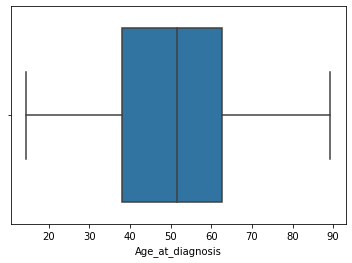

In [71]:
sns.boxplot(data=df, x='Age_at_diagnosis')

In [72]:
# Imputing missing age values w mean and not median bc boxplot shows no outliers
df['Age_at_diagnosis'].fillna(df['Age_at_diagnosis'].mean(), inplace=True)
df.describe()

,Grade,Age_at_diagnosis,IDH1,TP53,ATRX,PTEN,EGFR,CIC,MUC16,PIK3CA,...,CSMD3,SMARCA4,GRIN2A,IDH2,FAT4,PDGFRA,Race_american indian or alaska native,Race_asian,Race_black or african american,Race_white
count,840.000000,840.000000,840.000000,840.000000,840.000000,840.000000,840.000000,840.000000,840.000000,840.000000,...,840.000000,840.000000,840.000000,840.000000,840.000000,840.000000,840.000000,840.000000,840.000000,840.000000
mean,0.419048,50.873130,0.482143,0.414286,0.258333,0.167857,0.133333,0.132143,0.116667,0.086905,...,0.032143,0.032143,0.032143,0.027381,0.027381,0.026190,0.001190,0.016667,0.070238,0.911905
std,0.493697,15.633549,0.499979,0.492892,0.437979,0.373962,0.340137,0.338848,0.321214,0.281863,...,0.176484,0.176484,0.176484,0.163288,0.163288,0.159797,0.034503,0.128095,0.255700,0.283602
min,0.000000,14.420000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,38.062500,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
50%,0.000000,51.390000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
75%,1.000000,62.617500,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
max,1.000000,89.290000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


## Data visualization 

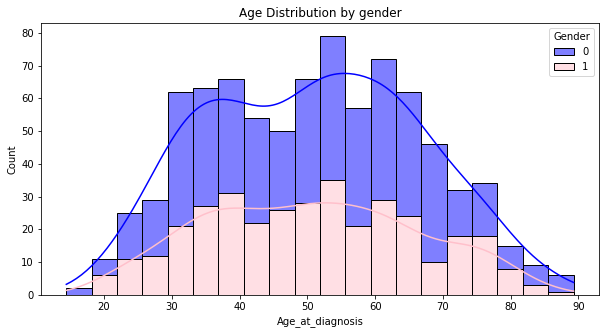

In [73]:
# Checking age distribution by gender
plt.figure(figsize=(10, 5))
sns.histplot(x='Age_at_diagnosis', data=df, hue='Gender', palette={0: 'blue', 1: 'pink'}, multiple='stack', bins=20, kde=True)
plt.title('Age Distribution by gender')
plt.show()

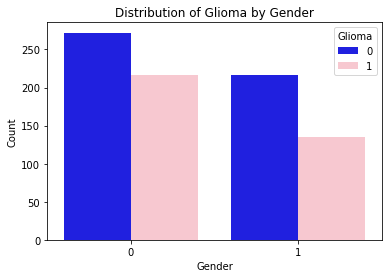

In [74]:
# Checking distribution of glioma by gender

sns.countplot(data=df, x='Gender', hue='Grade', palette={0: 'blue', 1: 'pink'})

plt.xlabel('Gender')
plt.ylabel('Count')
plt.title('Distribution of Glioma by Gender')
plt.legend(title='Glioma')

plt.show()

comment: Results: We identified mutations that affected amino acid 132 of IDH1 in more than 70% of WHO grade II and III astrocytomas and oligodendrogliomas and in glioblastomas that developed from these lower-grade lesions. Tumors without mutations in IDH1 often had mutations affecting the analogous amino acid (R172) of the IDH2 gene. Tumors with IDH1 or IDH2 mutations had distinctive genetic and clinical characteristics, and patients with such tumors had a better outcome than those with wild-type IDH genes. Each of four tested IDH1 and IDH2 mutations reduced the enzymatic activity of the encoded protein.

In [75]:
fig = make_subplots(rows=5, cols=4)

# Loop through columns 3 to 22 (indexing from 0 to 19)
column_names = []  # List to store column names for legend

for i, column in enumerate(df.iloc[:, 3:23].columns, start=1):
    row_num = (i - 1) // 4 + 1  # Calculate row number
    col_num = (i - 1) % 4 + 1   # Calculate column number

    value_counts = df[column].value_counts()

    fig.add_trace(
        go.Bar(x=value_counts.index, y=value_counts.values),
        row=row_num, col=col_num
    )
    
    column_names.append(f'Column {column}')  # Store column names for legend

    fig.update_xaxes(title_text=f'{column}', row=row_num, col=col_num)  # X-axis title

# Update layout for all subplots
fig.update_layout(title='Value Counts for Columns 3 to 22', width = 1000, height = 1200)
fig.for_each_trace(lambda trace: trace.update(name=column_names.pop(0)))  # Update trace names using stored column names
fig.show()

Explains why IDH1 mutations so prevalent (boxplot balanced). Also expect that correlation matrix will show inv corrs between idh1 and idh2

Other mutations imbalanced bc not all gliomas have all mutated genes

<AxesSubplot:>

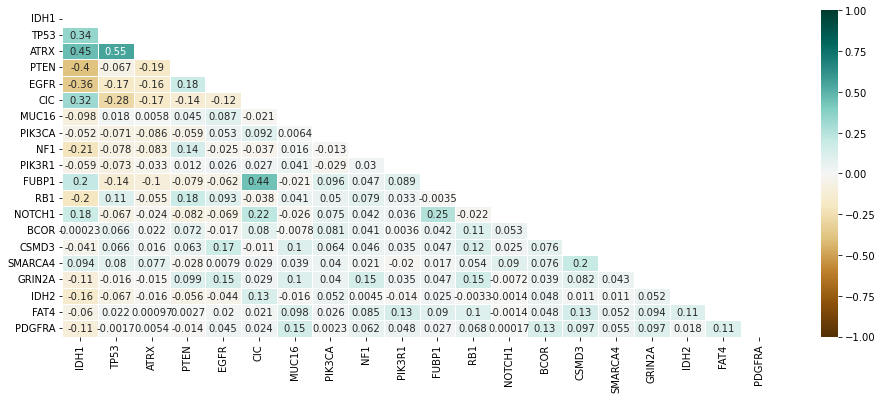

In [76]:
# Visualization of correlation between variables
plt.figure(figsize=(16, 6))
corr = df.iloc[:, 3 : 23].corr()

# Getting the Upper Triangle of the co-relation matrix
matrix = np.triu(corr)

# Using the upper triangle matrix as mask 
sns.heatmap(corr, annot=True, mask=matrix, vmin=-1, vmax=1, linewidths=.5, cmap='BrBG')

We will explain that we had initially hypothesized to use PCA because of the high dimensionality of the dataset. 
However, upon inspecting feature correlations (which we DID NOT DO WELL) and determining that we cannot establish a complete lack of linear correlation (bc of MENTION CORRELATIONS AND PAPER BACKED UP EVIDENCE) between features, we decided not to perform feature scaling. 

Yes, PCA can be applied even if there are many binary columns in your dataset. PCA operates on the correlation structure of the data, and it can be applied regardless of the type of data (binary, categorical, numerical, etc.). However, whether it's effective or advisable to use PCA with binary data depends on the specific characteristics of your dataset and your objectives.

When applying PCA to binary data, it's essential to consider a few points:

### Sparsity and Interpretation:
- **Sparsity:** Binary data often leads to sparse matrices, which might affect the effectiveness of PCA.
- **Interpretation:** Interpretability might be reduced as the principal components become linear combinations of binary variables.

### Variance Explained:
- **Explained Variance:** With binary data, the variance might not be well captured by principal components compared to continuous variables.

### Dimensionality Reduction:
- **Reducing Dimensionality:** Despite the above challenges, PCA might still help in reducing dimensionality and might be beneficial if the binary variables are highly correlated.

### Alternative Methods:
- **Alternative Techniques:** For binary data, alternative dimensionality reduction techniques like factor analysis or non-linear methods might be more suitable.

### Sparse PCA:
- **Sparse PCA:** There's also Sparse PCA, which is designed to handle sparse data more effectively by encouraging sparsity in the loadings.

Before applying PCA to binary data, consider the trade-offs and whether it aligns with your objectives, especially in terms of interpretability, explained variance, and the underlying structure of your data. Additionally, try different techniques and assess their effectiveness based on your specific use case and dataset characteristics.

## Model Selection

In [77]:
# Define label and features
X = df.drop(columns=['Grade'])
y = df['Grade']

In [78]:
# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, shuffle=True)

In [79]:
# Creating a list of potential models: 
models = []
model1 = LogisticRegression()
models.append(model1)
model2 = svm.SVC()
models.append(model2)
model3 = tree.DecisionTreeClassifier()
models.append(model3)
model4 = RandomForestClassifier()
models.append(model4)
models

[LogisticRegression(),
 SVC(),
 DecisionTreeClassifier(),
 RandomForestClassifier()]

LogisticRegression()
Accuracy of LogisticRegression() is 0.8611111111111112


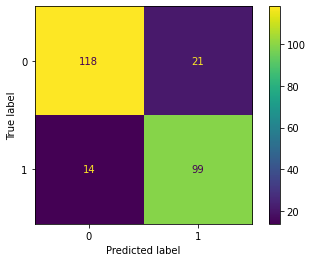

ROC AUC score of LogisticRegression() is 0.862513528999809


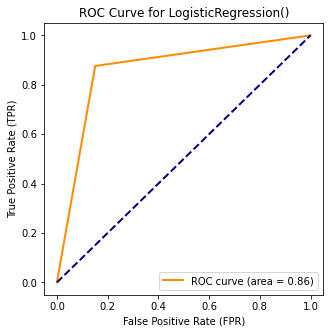

-------------------------------------------------------
SVC()
Accuracy of SVC() is 0.7380952380952381


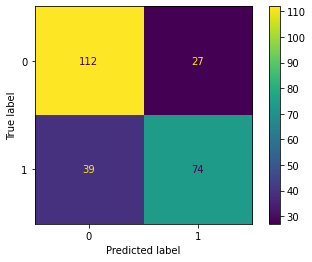

ROC AUC score of SVC() is 0.7303113261603108


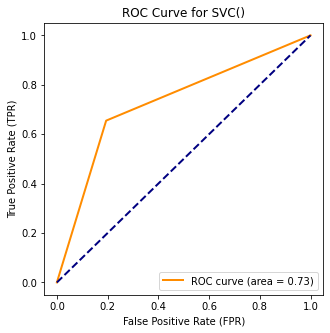

-------------------------------------------------------
DecisionTreeClassifier()
Accuracy of DecisionTreeClassifier() is 0.7976190476190477


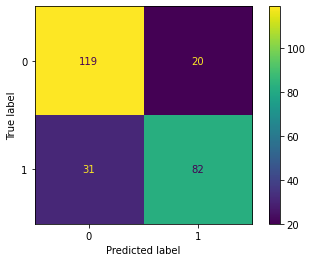

ROC AUC score of DecisionTreeClassifier() is 0.7908894123639142


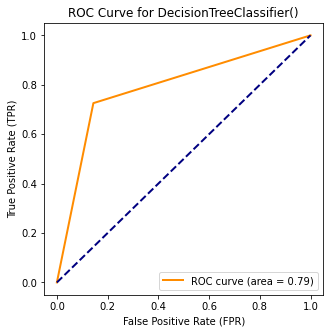

-------------------------------------------------------
RandomForestClassifier()
Accuracy of RandomForestClassifier() is 0.8214285714285714


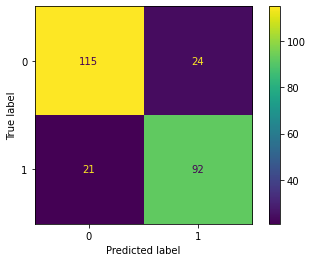

ROC AUC score of RandomForestClassifier() is 0.8207487107659005


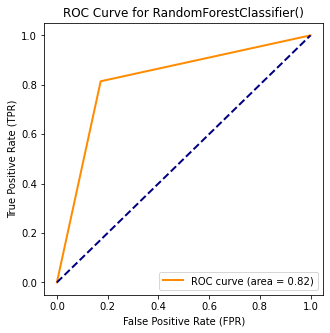

-------------------------------------------------------


In [80]:
# Creating dict for storing model's accuracy 
dict = {}
# Model evaluation with accuracy, cm, f1, roc scores
for model in models:
    print(model)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    accuracy = accuracy_score(y_test, y_pred)
    # Add key-value pair to the dictionary
    dict[model] = round(accuracy, 2)
    print(f"Accuracy of {model} is {accuracy}")

    cm = confusion_matrix(y_test, y_pred, labels = model.classes_)
    disp = ConfusionMatrixDisplay(confusion_matrix = cm, display_labels = model.classes_)
    disp.plot()
    plt.show()

    roc_auc = roc_auc_score(y_test, y_pred)
    print(f"ROC AUC score of {model} is {roc_auc}")

    # Compute ROC curve and AUC
    fpr, tpr, thresholds = roc_curve(y_test, y_pred)
    roc_auc = auc(fpr, tpr)

    # Plot ROC curve
    plt.figure(figsize=(5, 5))
    plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = {:.2f})'.format(roc_auc))
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlabel('False Positive Rate (FPR)')
    plt.ylabel('True Positive Rate (TPR)')
    plt.title(f'ROC Curve for {model}')
    plt.legend(loc='lower right')
    plt.show()
    print("-------------------------------------------------------")

In [81]:
# Getting first two models with the best accuracy
sorted_dict = OrderedDict(sorted(dict.items(), key = itemgetter(1), reverse = True))
first2pairs = {k: sorted_dict[k] for k in list(sorted_dict)[:2]}
first2pairs

{LogisticRegression(): 0.86, RandomForestClassifier(): 0.82}

In [82]:
# Removing models from models list that didnt performe well
keys = first2pairs.keys()
models = [model for model in models if model in keys]
models

[LogisticRegression(), RandomForestClassifier()]

In [83]:
#cross validation
splits = [5, 10] #trying 5 and 10 folds
for i in splits:
    kf = KFold(n_splits = i, shuffle = True, random_state = 42)
    for model in models:
        accuracy = cross_val_score(model, X_train, y_train, cv=kf, scoring='accuracy')
        # f1 = cross_val_score(model, X_train, y_train, cv=kf, scoring='f1')
        # roc_auc = cross_val_score(model, X_train, y_train,cv=kf, scoring='roc_auc')
        # recall = cross_val_score(model, X_train, y_train, cv = kf, scoring = 'recall')
        print(f'''
                Accuracy of {model} for {i} splits is {round(accuracy.mean(), 5)} 
            ''')
    print("                ---------------------------------------------------------------")


#dict: model + splits: accuracy for EVERY model OR everything in one dictionary


                Accuracy of LogisticRegression() for 5 splits is 0.86733 
            

                Accuracy of RandomForestClassifier() for 5 splits is 0.83157 
            
                ---------------------------------------------------------------

                Accuracy of LogisticRegression() for 10 splits is 0.87072 
            

                Accuracy of RandomForestClassifier() for 10 splits is 0.83326 
            
                ---------------------------------------------------------------


In [84]:
#5 folds is best , TODO: decide if AUC-ROC/ recall/ accuracy /f1 scores based on our dataset


# USE DATA FROM DICT BELOW TO DEFINE K_SPLITS

In [85]:
kf = KFold(n_splits=5, shuffle=True, random_state=42)

In [86]:
# GridSearchCV for logistic regression

param_grid = [    
    {'penalty' : ['l1', 'l2', 'elasticnet', 'none'],
    #'C' : [0.001,0.01,0.1,1,10,100,1000], #this is not granular enough TODO: MENTION IN REPORT 
    'C': np.logspace(-4, 4, 20), #more granular params bc evenly dsitributed in logspace
    'solver' : ['lbfgs', 'newton-cg', 'liblinear', 'sag', 'saga']
    }
]

grid_search = GridSearchCV(estimator = models[0],
                           param_grid = param_grid,
                           scoring = 'accuracy',
                           cv = kf).fit(X_train, y_train)

# Get the best estimator
best_model = grid_search.best_estimator_

print(f"Best parameters: {grid_search.best_params_}")
print(f"Best cross-validation score: {grid_search.best_score_}")

Best parameters: {'C': 4.281332398719396, 'penalty': 'l2', 'solver': 'newton-cg'}
Best cross-validation score: 0.8775749674054758


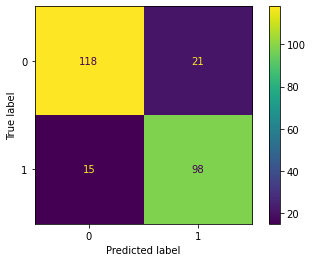

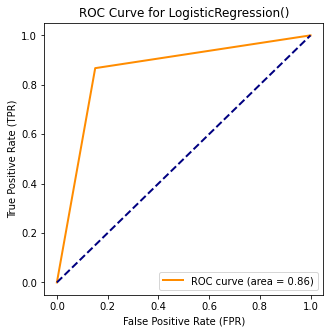

Accuracy of new LogisticRegression is 0.8571428571428571


In [87]:
# y_pred with the best parameters from GridSearchCV
y_pred_g = best_model.predict(X_test)


accuracy_g = accuracy_score(y_test, y_pred_g)
cm = confusion_matrix(y_test, y_pred_g, labels = models[0].classes_)
disp = ConfusionMatrixDisplay(confusion_matrix = cm, display_labels = models[0].classes_)
disp.plot()
plt.show()

# Compute ROC curve and AUC
fpr, tpr, thresholds = roc_curve(y_test, y_pred_g)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure(figsize=(5, 5))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = {:.2f})'.format(roc_auc))
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title(f'ROC Curve for {models[0]}')
plt.legend(loc='lower right')
plt.show()
print(f"Accuracy of new LogisticRegression is {accuracy_g}")

In [88]:
y_pred = models[0].predict(X_test)
prev_accuracy = accuracy_score(y_test, y_pred)
print(f"Previous accuracy of LogisticRegression is {prev_accuracy}")

if accuracy_g > prev_accuracy:
    print("Accuracy improved after gridsearch")
else: 
    print("Accuracy did not improve after gridsearch")

Previous accuracy of LogisticRegression is 0.8611111111111112
Accuracy did not improve after gridsearch


________________________________________________________________________________________________________________________

1. kfold cross validation (5,10)


2. use diff grid search hyperparameters to determine which best between randomforestclassifier and logistic regression 

3. kfold cross validation 

In [89]:
#random forest was second best model, so grid search for random forest to see if tuning hyperparams improves accuracy/whatever metric we end up picking

#FPR RANDOM FOREST find values

param_grid = [    

    }
]

grid_search = GridSearchCV(estimator=model1,
                           param_grid=param_grid,
                           scoring='accuracy',
                           cv=5).fit(X_train, y_train)

print(f"Best parameters: {grid_search.best_params_}")
print(f"Best cross-validation score: {grid_search.best_score_}")


SyntaxError: closing parenthesis '}' does not match opening parenthesis '[' on line 5 (3938984704.py, line 7)

In [ ]:
#pick which best bewten rf and lr after hyperparametter turning

In [ ]:
#when found best params plt smth like this 


#Scatter plot for the actual training values
scatter = go.Scatter(x = x_train.values.flatten(), y=y_train.values.flatten(), mode='markers', name='Actual')
#line plot for the predicted training values
line = go.Scatter(x = x_train.values.flatten(), y=y_pred.values.flatten(), mode='lines', name='Predicted')
layout = go.Layout(title='Actual vs Predicted, train set', xaxis=dict(title='population'), yaxis=dict(title='profit'))
data = [scatter, line]
figtr = go.Figure(data=data, layout=layout)
figtr.show()


#predict new values based on the test set


#scatter for  y test values
scatter = go.Scatter(x = x_test.values.flatten(), y=y_test.values.flatten(), mode='markers', name='Actual')
#line for predicted y values 
line = go.Scatter(x = x_test.values.flatten(), y=new_y.values.flatten(), mode='lines', name='Predicted')
layout = go.Layout(title='Actual vs Predicted, test set', xaxis=dict(title='population'), yaxis=dict(title='profit'))
data = [scatter, line]
figte = go.Figure(data=data, layout=layout)
figte.show()


# Points to discuss

**EDA**

- check if shared things between na in age before just going w mean refill. are they actually outliers?

**Correlation matrix**

- look into who doesnt have mutations in idh1 and 2 -> is each of them related to a different glioma grade? 

- look at correlations of high values between themselves: are they more correlated to one specific form of glioma? we expect more associated with GBM based on literature 

**PCA**

- most correlated components in corr matrix are linked to GBM mostly, so can we still do PCA? can we cluster them?

**GRID SEARCH**

- random search outperforms grid search so try both. 


**Relevant notes on genes**

- p53: tumor suppressor gene, Dna damage and repair! mutations in p53 are associated with many cancers, including gliomas esp GBM

- grin2a: less involved in DNA repair, so mutation here is less bad 

- look at corrs between ATRX and p53, and are tehy linked to one specific kind of glioma more than others? 

- if highly correlated, check if they dont just exist in same place in dna

- atrx is chromosome x and p53 is chromosome 17, so they are not just in same place in dna -> can claim causation? 




<AxesSubplot:>

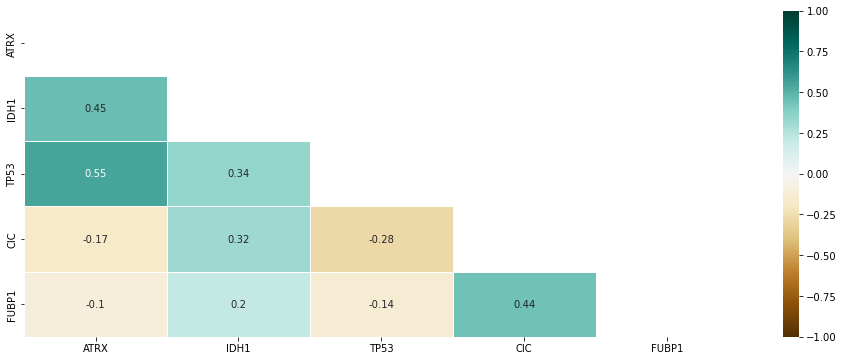

In [91]:
# Plotting only genes that showed correlation among them, for better visualization
correlated_genes = ['ATRX', 'IDH1', 'TP53', 'CIC', 'FUBP1']
plt.figure(figsize=(16, 6))
corr2 = df[correlated_genes].corr()

# Getting the Upper Triangle of the co-relation matrix
matrix2 = np.triu(corr2)


sns.heatmap(corr2, annot=True, mask=matrix2, vmin=-1, vmax=1, linewidths=.5, cmap='BrBG')

ATRX and IDH1 : 0.45

ATRX and TP53 : 0.55

IDH1 and TP53 : 0.34

CIC and FUBP1 : 0.44

CIC and IDH1 : 0.32 

All of these genes are fundamental in cancer development, they are involved in tasks such as cell division regulation, transcriptional repression, tumor growth interruption under unfavorable conditions (e.g. tumors), DNA structure modification. 

It is reasonable to expect that these genes would be most correlated to higher grades glioma. 
Need to determine whether this can be taken as enough evidence to "cluster" them and do PCA.


<AxesSubplot:>

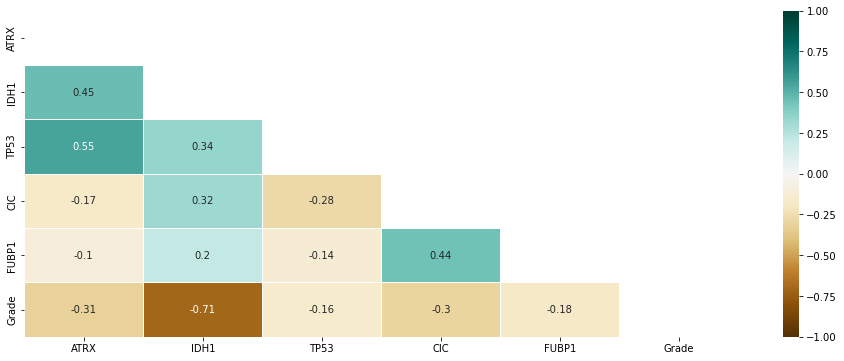

In [92]:
# Plotting selected genes correlation with glioma grade 
plt.figure(figsize=(16, 6))
corr_genesglioma = correlated_genes = ['ATRX', 'IDH1', 'TP53', 'CIC', 'FUBP1' , 'Grade']
corr3 = df[corr_genesglioma].corr()

# Getting the Upper Triangle of the co-relation matrix
matrix3 = np.triu(corr3)


sns.heatmap(corr3, annot=True, mask=matrix3, vmin=-1, vmax=1, linewidths=.5, cmap='BrBG')

#stronger correlation means that if the genes are mutated, the grade is more likely to be GBM. This is because we assigned 1 to mutation and 1 to GBM.